# Parameters

In [1]:
# ------- PARAMETERS ------- #

RUNS = [17]               # run indexes

root = '/pnfs/pic.es/data/cta/LST/LST2/Data/ZFITS/' # path to all folders with the .zfits files

# -------------------------- #

# other parameters

dir_files  = '/data/cta/users-ifae/summer_students/jjimenezq/PEDESTAL_ANALYSIS-LST2/csv_files/'#''csv_files/' # path (relative or absolute) to the .csv files
dir_graphs = 'graphs/'    # path (relative or absolute) to the images created

subrun        = 0         # subrun to analyse
graphs_format = 'pdf'     # file format of images
random_pixels = 5         # number of random pixels we extract the plots

Some packages needed

In [2]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import auxiliar          as aux
aux.parameters()

from ctapipe.instrument    import CameraGeometry
from ctapipe.visualization import CameraDisplay
from ctapipe.coordinates   import EngineeringCameraFrame
from traitlets.config      import Config
from ctapipe.io            import EventSource

# extracting the number of LST
LST_camera = aux.find_LST_num(root) 

# getting geometry of the camera
date, subruns = aux.search(root,RUNS[0])    
config  = Config({'LSTEventSource': {'default_trigger_type': 'ucts','allowed_tels': [1],
                                    'min_flatfield_adc': 3000,'min_flatfield_pixel_fraction': 0.8,},})  
path    = root+date+'/'+'LST-'+LST_camera+'.1.Run'+str(RUNS[0]).zfill(5)+'.'+str(subrun).zfill(4)+'.fits.fz'
source  = EventSource( input_url = path ,config = config)
camgeom = source.subarray.tel[1].camera.geometry

# creating the folder if dont exist
aux.create_folder(dir_graphs)        

# 60 seconds average plots

Analysing the average value of pedestals for a run averaging every 60 seconds

Reading CSV for run 17...

Run 17, pixel 496


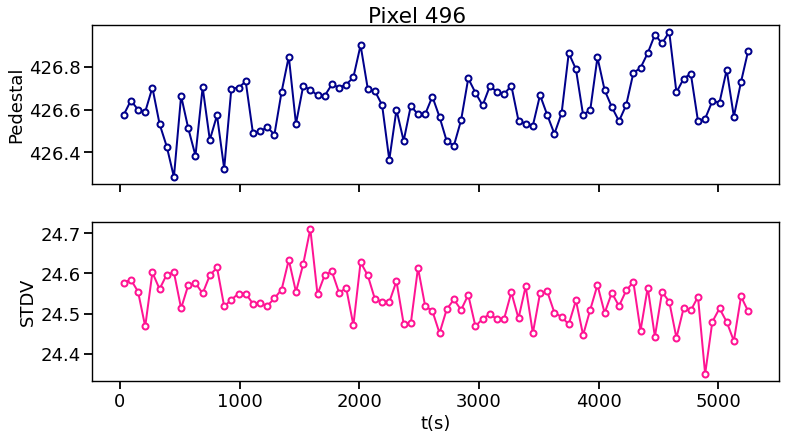

Run 17, pixel 72


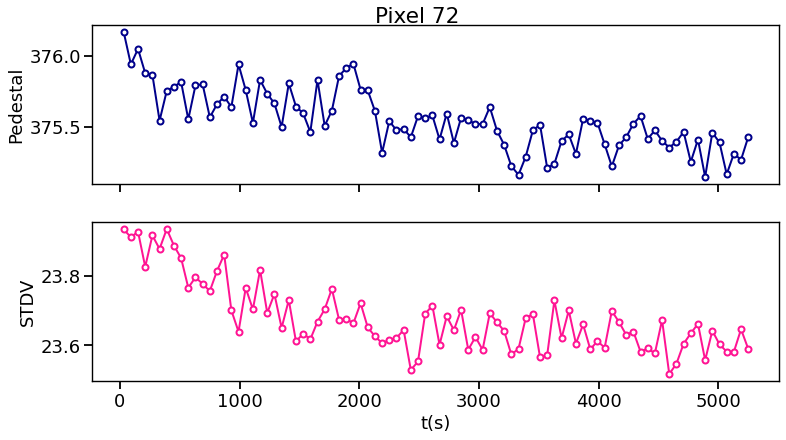

Run 17, pixel 1283


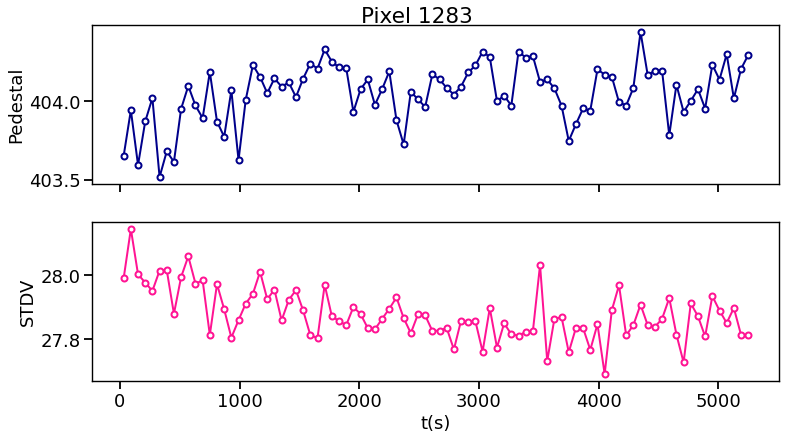

Run 17, pixel 1193


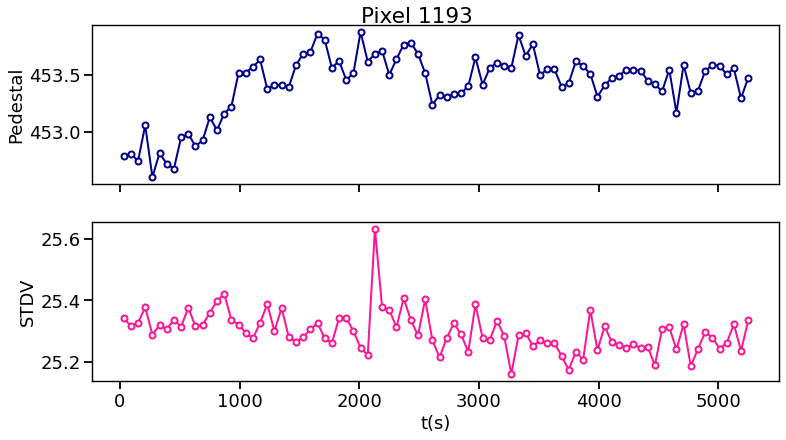

Run 17, pixel 295


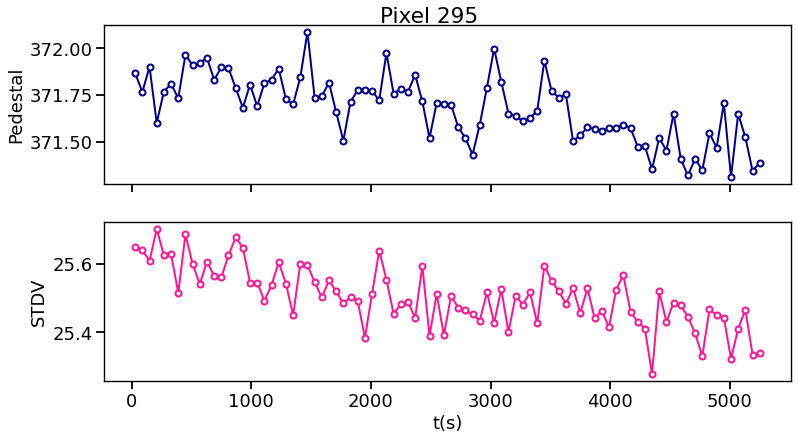


--------------------------------------------------
--------------------------------------------------



In [3]:
for run in RUNS:
    
    # N random pixels analysis for each run
    indexes = np.random.rand(random_pixels) * 1855
    indexes = np.array([int(indexes[i]) for i in range(len(indexes))])    
    
    # reading run
    print('Reading CSV for run '   + str(run) + '...\n')
    path = dir_files + 'data_Run' + str(run) + '_Subrun' + str(0) + '.csv'
    df   = pd.read_csv(path)

    # iterating over N random pixels
    for pixel in indexes:
        print('Run ' + str(run) + ', pixel ' + str(pixel+1))
        
        # reading only the pixel data
        pedestal = df.iloc[:, pixel * 2 + 1]
        stdv     = df.iloc[:, pixel * 2 + 2]
        time     = df.iloc[:, 0]
        time     = time - time[0]            # taking as reference the 0 time

        pedestal60, stdv60, time60 = [], [], []
        
        t0, tf, ind = 0, None, 0
        for t in range(len(time)):
            
            # saving mean values in each 60 seconds
            if (time[t] - t0) >= 60:
                pedestal60.append(np.mean(pedestal[ind:t]))
                stdv60.append(np.mean(stdv[ind:t]))
                time60.append(np.mean(time[ind:t]))
                t0  = t0 + 60
                ind = t
        
        # plotting the average values in time
        fig,(ax1,ax2) = plt.subplots(2,1, figsize=(11,6), sharex='col')
        fig.tight_layout()
        fig.suptitle('Pixel '+str(pixel + 1))

        ax1.plot(time60, pedestal60, '-', color='darkblue', marker='o', markerfacecolor='white',)
        ax2.plot(time60, stdv60,     '-', color='deeppink', marker='o', markerfacecolor='white',)

        ax1.set_ylabel('Pedestal')
        ax2.set_xlabel('t(s)')
        ax2.set_ylabel('STDV')

        plt.savefig(dir_graphs + '60avg_Run' + str(run) + '_Subrun' + str(subrun) + '_Px' +
                    str(pixel+1) + '.' + graphs_format, bbox_inches='tight', format=graphs_format)
        plt.show()    
    
    del df  # deleting to clean memory
     
    print('\n' + '-' * 50 + '\n' + '-' * 50 + '\n')

# 300 first and last seconds analysis

Analysing the first and last 300 seconds of a run

Reading CSV for Run 17...

Finished reading 

Finding 300 first elements...
Finished 

Finding 300 last elements...
Finished 

Means and ratios calculus...
Finished 



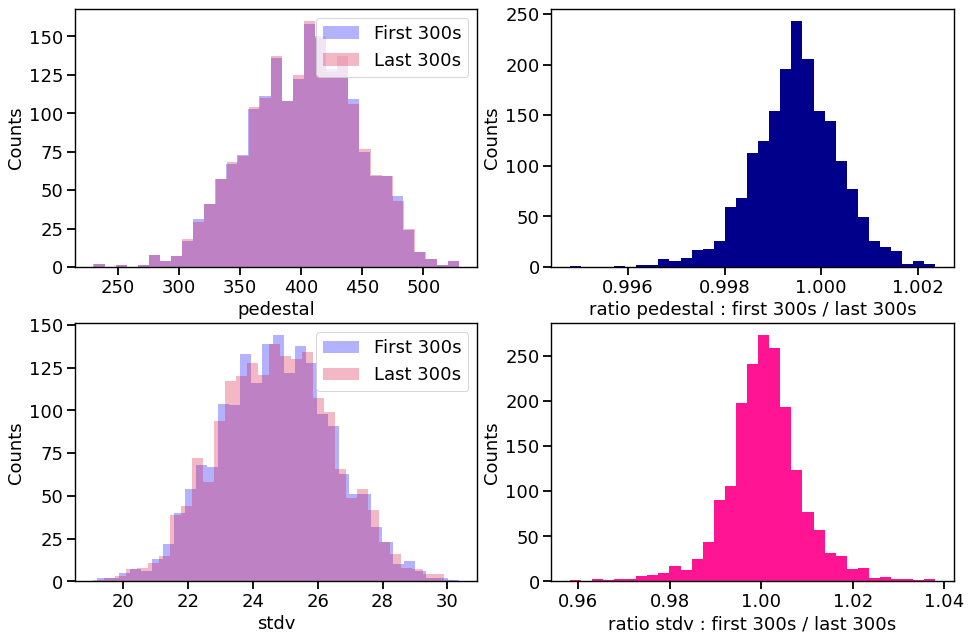

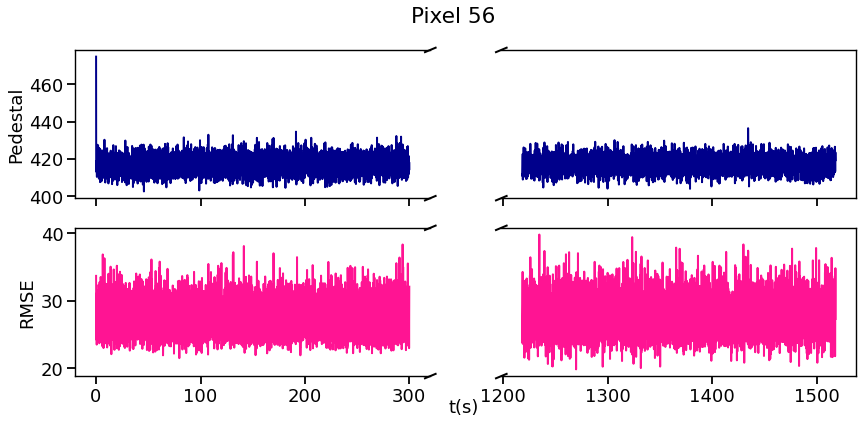

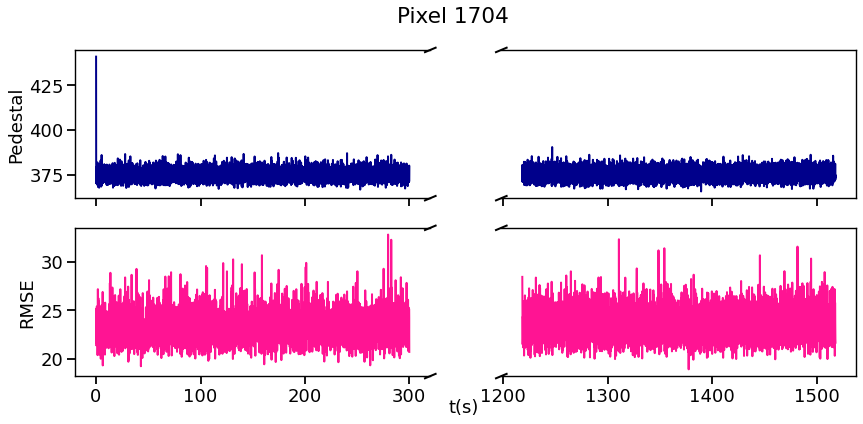

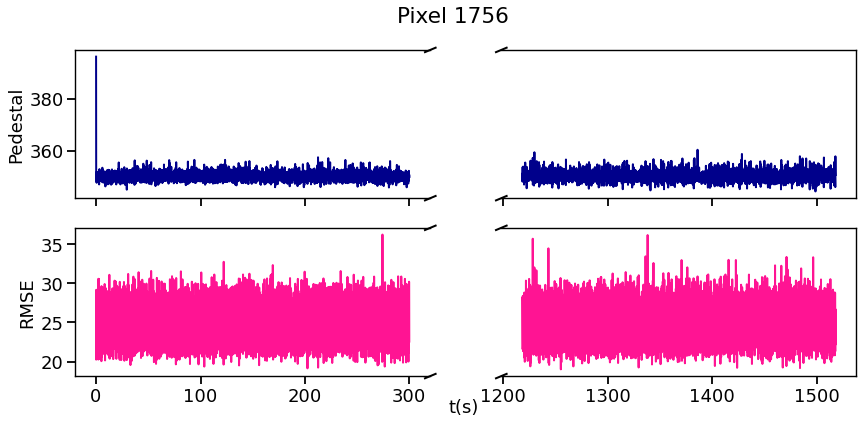

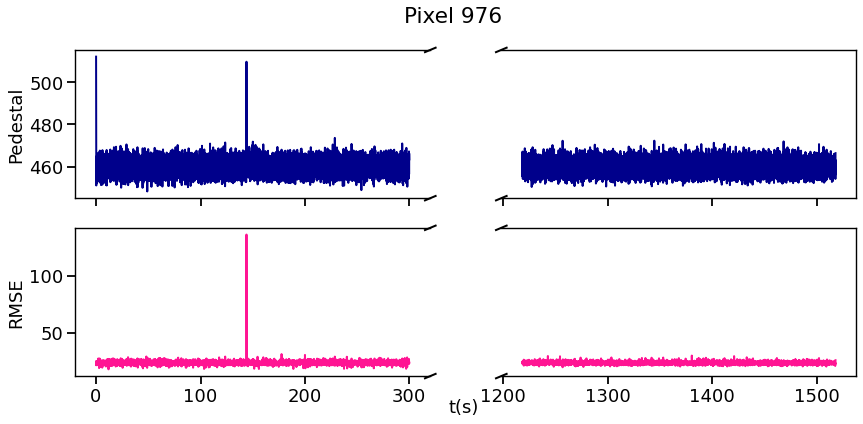

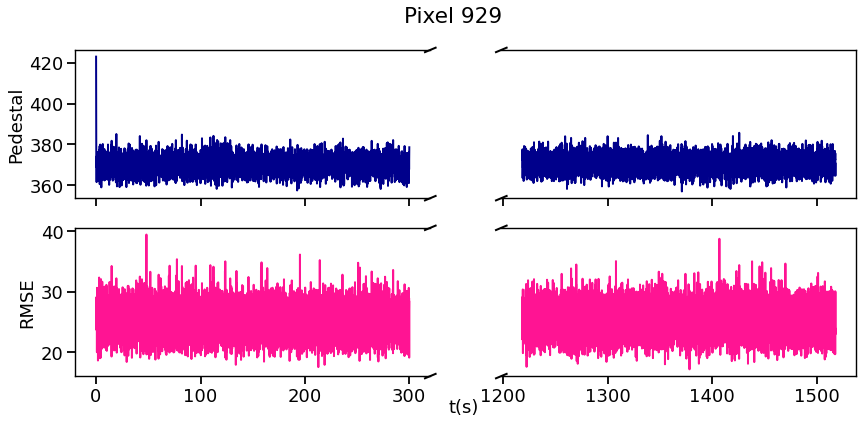

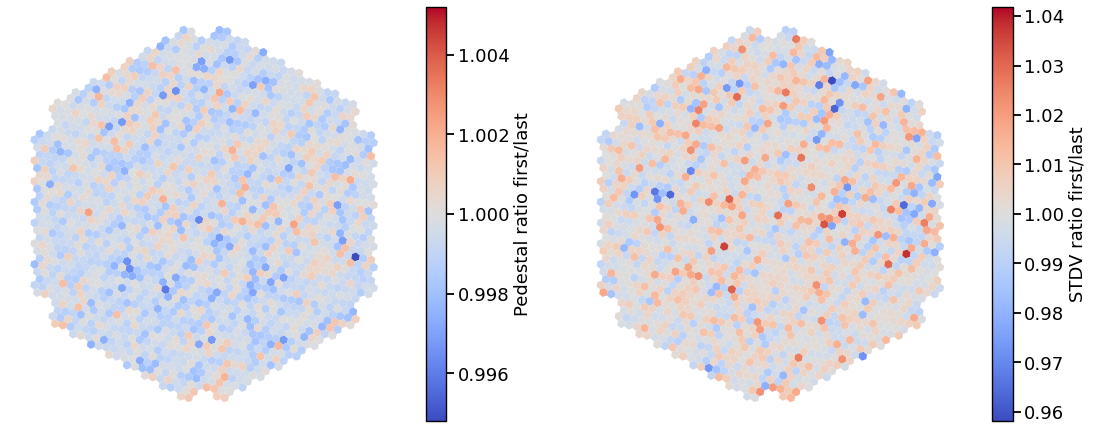


--------------------------------------------------
--------------------------------------------------



In [5]:
# iterating over all runs
for run in RUNS:
    
    
    # data reding --------------------------------
    # reading initial subrun data
    print('Reading CSV for Run '+str(run)+'...\n') 
    path = dir_files + 'data_Run' + str(run) + '_Subrun' + str(0) + '.csv'
    df   = pd.read_csv(path)
    
    pedestal = []
    stdv     = []
    time     = df.iloc[:,0]
    time     = time - time[0]     #taking as reference the 0 time    
    
    for pixel in range(1855):
        pedestal.append(df.iloc[:,pixel*2+1])
        stdv.append(    df.iloc[:,pixel*2+2])

    # initial subrun data
    pedestalInitTotal = pedestal.copy()
    stdvInitTotal     = stdv.copy()
    timeInitTotal     = time.copy()
    
    # if the last subrun is 0, the 300s will be also inside same subrun
    # finding what subrun is the last one
    date, subruns = aux.search(root, run)
        
    if subruns[-1] == 0:
        pedestalEndTotal = pedestal.copy()
        stdvEndTotal     = stdv.copy()
        timeEndTotal     = time.copy()
    
    else:
        
        # reading last subrun data
        path = dir_files + 'data_Run'+str(run)+'_Subrun'+str(subruns[-1])+'.csv'
        df  = pd.read_csv(path)
        
        pedestal = []
        stdv     = []
        time     = df.iloc[:,0]
        time     = time - time[0]     #taking as reference the 0 time    

        for pixel in range(1855):
            pedestal.append(df.iloc[:,pixel*2+1])
            stdv.append(    df.iloc[:,pixel*2+2])    
            
        pedestalEndTotal = pedestal.copy()
        stdvEndTotal     = stdv.copy()
        timeEndTotal     = time.copy()
        
    print('Finished reading \n')    
    #-----------------------------------------------
    
    # extacting only the first and last 300 seconds
    # first  300s
    pedestalInit = [] 
    stdvInit     = []
    timeInit     = []
    print('Finding 300 first elements...') 
    for ev in range(len(timeInitTotal)):
        
        if timeInitTotal[ev] <= 300:
            
            pedestalInit.append([pedestalInitTotal[px][ev] for px in range(1855)])
            stdvInit.append([stdvInitTotal[px][ev]         for px in range(1855)])
            timeInit.append(timeInitTotal[ev])
            
        else:
            print('Finished \n')
            break

    # last  300s
    pedestalEnd = [] 
    stdvEnd     = []
    timeEnd     = []
    print('Finding 300 last elements...') 
    for ev in reversed(range(len(timeEndTotal))):        
        
        if (timeEndTotal[timeEndTotal.size-1]-timeEndTotal[ev])<=300:
            
            pedestalEnd.append([pedestalEndTotal[px][ev] for px in range(1855)])
            stdvEnd.append([stdvEndTotal[px][ev]         for px in range(1855)])
            timeEnd.append(timeEndTotal[ev])
            
        else:
            print('Finished \n')
            break
    
    #reversing again
    pedestalEnd = [pedestalEnd[i] for i in reversed(range(len(pedestalEnd)))]
    stdvEnd     = [stdvEnd[i]     for i in reversed(range(len(stdvEnd)))    ]
    timeEnd     = [timeEnd[i]     for i in reversed(range(len(timeEnd)))    ]
            
    print('Means and ratios calculus...')
    # transposing to get M[px][ev]
    pedestalInit = np.transpose(pedestalInit)
    stdvInit     = np.transpose(stdvInit)
    pedestalEnd  = np.transpose(pedestalEnd)
    stdvEnd      = np.transpose(stdvEnd)
    
    # mean and stdv initial points, over events
    pedestalInitMean = [np.mean(pedestalInit[px]) for px in range(1855)]
    stdvInitMean     = [np.mean(stdvInit[px])     for px in range(1855)]
    # mean and stdv final points, over events
    pedestalEndMean  = [np.mean(pedestalEnd[px])  for px in range(1855)]
    stdvEndMean      = [np.mean(stdvEnd[px])      for px in range(1855)]    
    
    ratioPedestal = [ pedestalInitMean[px] / pedestalEndMean[px] for px in range(1855)]
    ratioStdv     = [ stdvInitMean[px] / stdvEndMean[px]         for px in range(1855)]
    print('Finished \n')
        
    
    # --------- ratios histogram --------- #
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(13.5, 9))
    fig.tight_layout()
    
    # ax1 pedestal means 
    ax1.hist(pedestalInitMean, alpha=0.3, bins=33, color='blue',    label='First 300s', histtype='stepfilled')
    ax1.hist(pedestalEndMean,  alpha=0.3, bins=33, color='crimson', label='Last 300s',  histtype='stepfilled')
    ax1.set_ylabel('Counts')
    ax1.set_xlabel('pedestal')
    ax1.legend()

    # ax2 pedestal ratios 
    ax2.hist(ratioPedestal, bins=33, color='darkblue', histtype='stepfilled')
    ax2.set_xlabel('ratio pedestal : first 300s / last 300s')
    ax2.set_ylabel('Counts')

    # ax3 stdv means
    ax3.hist(stdvInitMean, alpha=0.3, bins=33, color='blue',    label='First 300s', histtype='stepfilled')
    ax3.hist(stdvEndMean,  alpha=0.3, bins=33, color='crimson', label='Last 300s',  histtype='stepfilled')
    ax3.set_ylabel('Counts')
    ax3.set_xlabel('STDV')
    ax3.legend()

    # ax4 stdv ratios
    ax4.hist(ratioStdv, bins=33, color='deeppink', histtype='stepfilled')
    ax4.set_xlabel('ratio stdv : first 300s / last 300s')
    ax4.set_ylabel('Counts')

    plt.savefig(dir_graphs + '300s_hists_Run' + str(run) + '.' + graphs_format,
                bbox_inches='tight', format=graphs_format)
    plt.show()
    # ------------------------------------ #
    
    # --------- pixels examples ---------- #
    indexes = [int(np.random.rand() * 1855) for i in range(random_pixels)]
    
    d = .015 #size of the axis break
    for pixel in indexes:

        fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharey='row',sharex='col',facecolor='w',figsize=(14,6))
        fig.suptitle('Pixel ' + str(pixel+1))
        
        # x label plotting
        fig.text(0.51, 0.04, 't(s)', ha='center')

        # ax1-ax2 pedestal
        ax1.plot(timeInit, pedestalInit[pixel], color='darkblue')
        ax1.set_xlim(-20, 320)
        ax1.spines['right'].set_visible(False)
        kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
        ax1.plot((1-d, 1+d), (-d ,  +d), **kwargs)
        ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)
        ax1.set_ylabel('Pedestal')

        ax2.plot(timeEnd, pedestalEnd[pixel], color='darkblue')
        ax2.set_xlim(timeEnd[-1] - 320, timeEnd[-1] + 20)
        ax2.spines['left'].set_visible(False)
        ax2.tick_params(axis='y', which='both', left=False, labelleft=False)
        kwargs.update(transform=ax2.transAxes)  
        ax2.plot((-d,+d), (1-d, 1+d), **kwargs)
        ax2.plot((-d,+d), (-d ,  +d), **kwargs)

        # ax3-ax4 stdv 
        ax3.plot(timeInit, stdvInit[pixel], color='deeppink')
        ax3.set_xlim(-20, 320)
        ax3.spines['right'].set_visible(False)
        kwargs = dict(transform=ax3.transAxes, color='k', clip_on=False)
        ax3.plot((1-d, 1+d), (-d ,  +d), **kwargs)
        ax3.plot((1-d, 1+d), (1-d, 1+d), **kwargs)        
        ax3.set_ylabel('STDV')

        ax4.plot(timeEnd, stdvEnd[pixel], color='deeppink')
        ax4.set_xlim(timeEnd[-1] - 320, timeEnd[-1] + 20)
        ax4.spines['left'].set_visible(False)
        ax4.tick_params(axis='y', which='both', left=False, labelleft=False)
        kwargs.update(transform=ax4.transAxes)  
        ax4.plot((-d, +d), (1-d, 1+d), **kwargs)
        ax4.plot((-d, +d), (-d ,  +d), **kwargs)        

        plt.savefig(dir_graphs + '300s_Run' + str(run) + '_Px' + str(pixel+1) +
                    '.' + graphs_format, bbox_inches='tight', format=graphs_format)
        plt.show()  
    # ------------------------------------- #
    
    # ------------ camera plot ------------ #
    fig,(ax1,ax2) = plt.subplots(1,2, figsize=(16,6.8))
    fig.tight_layout()

    camdisplay = CameraDisplay(camgeom.transform_to(EngineeringCameraFrame()), ax=ax1, image=ratioPedestal,
                                norm=colors.CenteredNorm(1), show_frame=False, cmap='coolwarm', title='')
    camdisplay.add_colorbar(label='Pedestal ratio first/last')
    ax1.invert_xaxis()
    ax1.invert_yaxis()
    ax1.set_axis_off()

    camdisplay =CameraDisplay(camgeom.transform_to(EngineeringCameraFrame()), ax=ax2, image=ratioStdv,
                              norm=colors.CenteredNorm(1), show_frame=False, cmap='coolwarm', title='')
    camdisplay.add_colorbar(label='STDV ratio first/last')
    ax2.invert_xaxis()
    ax2.invert_yaxis()
    ax2.set_axis_off()

    plt.savefig(dir_graphs + 'total_cameraPlot_Run' + str(run) + '_Subrun' + str(subrun) + '.' + 
                graphs_format, bbox_inches='tight', format=graphs_format) 
    plt.show()    
    # -------------------------------------- #

    print('\n' + '-' * 50 + '\n' + '-' * 50 + '\n')